# Monte Carlo Radiative Transfer

## Background

### Important Variables

- Specific Intensity $I_v$ or $I(\mathbf{x}, t, \nu)$
- $\mathbf{x}$ position in space
- $\mu$ propagation direction
- $t$ time
- $\nu$ frequency
- $\chi_a$ absorption coefficient
- $\chi_s$ scattering coefficient
- $\chi_t = \chi_a + \chi_s$ total extinction coefficient or opacity

The radiative transfer equation describes the propagation of light through a medium. Let us start by assuming the light propagates through empty space then

$$
\frac{dI_v}{ds} = 0
$$

where $I$ is the intensity of light and $s$ is the distance traveled. Let us add a radiation absorbing medium to the mix. The radiative transfer equation then becomes

$$
\frac{dI_v}{ds} = -\alpha_v I_v
$$

where $\alpha$ is the *fractioanl depletion coefficient* per path length. We can define the optical depth $\tau$ as

$$
d \tau_v = -\alpha_v ds
$$

and the radiative transfer equation becomes

$$
\frac{dI_v}{d\tau_v} = -I_v
$$

However radiation can also travel through a radiation emitting medium. The radiative transfer equation then becomes

$$
\frac{dI_v}{ds} = -\alpha_v I_v + j_v
$$

where $j$ is the *emission coefficient*. We can also define it in terms of the optical depth

$$
\frac{dI_v}{d\tau_v} = \frac{j_v}{\alpha_v} - I_v.
$$

We then define the source function as 

$$
S_v = \frac{j_v}{\alpha_v}
$$

and the radiative transfer equation becomes

$$
\frac{dI_v}{d\tau_v} = S_v - I_v.
$$

## MCRT 

We can simulate the radiative transfer equation using Monte Carlo methods. We leverage an abstraction called photon packets, or machine photons, where a number of photons are grouped together. The photons are described by their position, direction, frequency, energy and weight. Over the course of the simulation, each photon packet continously accumulates optical depth. Hence contrary to classical simulations, we do not integrate over time but over optical depth.



We treat interactions with the medium as discrete interaction events, hence the MC algorithm needs to find when those events occur. We denote a random number as $\xi$. At the beginning of each packet trajectory event, each packet is assigned a new optical depth distance to the next interaction by

$$
\tau = -\log(\xi)
$$

we then compute the length of the path in physical space by dividing the optical depth by the total extinction coefficient $\chi_a$

$$
l = \frac{\tau}{\chi_a}
$$

of if we include scattering

$$
l = \frac{\tau}{\chi_t}.
$$

We can then update the position of the photon packet by

$$
\mathbf{x} = \mathbf{x} + l \mathbf{\mu}
$$

where $\mathbf{\mu}$ is the direction of the photon packet. For the case of pure absorption, the packet is absorbed and the simulation ends. If we include scattering, we need to determine if the photon packet is scattered which happens when

$$
\xi \leq \frac{\chi_s}{\chi_t}
$$

where $\xi$ is a random number between 0 and 1. If the photon packet is scattered, we need to draw a new direction for the photon packet

$$
\mathbf{\mu} = \xi - 1.
$$

In [1]:
using Plots

In [2]:
# We define the Photon Packets
mutable struct PP
    # position in physical space
    pos::AbstractArray{Float64, 1}
    # propagation direction
    mu::AbstractArray{Float64, 1}
    # state of the packet, False means the photon has escaped
    absorbed::AbstractArray{Bool, 1}
    escaped::AbstractArray{Bool, 1}
end

In [47]:
struct Params
    # scattering coefficient
    chi_scattering::Float64
    # absorbtion coefficient
    chi_absorbtion::Float64
    # boundary of the domain
    boundary::Float64
    # enable scattering -> Drawing new directions
    enable_scattering::Bool
end

function event(p::PP, params::Params)::Nothing

    N = size(p.pos)[1]

    # sample optical depth to next event
    tau_to_next = -log.(rand(Float64, N))

    # set chi total / opacity 
    chi_tot = params.chi_absorbtion
    if params.enable_scattering
        chi_tot += params.chi_scattering
    end
    
    # Invert the optical depth to get the phyiscal distance. 
    # Note that this is an approximation, as we cannot invert the integral over chi as there is no unique solution (?)
    l_to_next = tau_to_next ./ chi_tot

    # Update the state of the packets
    p.pos .+= l_to_next .* p.mu

    # Decide if packets crossed boundaries
    escaped = (p.pos .> params.boundary) .|| (p.pos .< -params.boundary)

    println("New escaped: ", sum(escaped))
    
    # Update the escape state of the packets
    p.escaped = p.escaped .|| (escaped .&& .!p.absorbed)

    # Decide if packets are scattered or absorbed 
    if params.enable_scattering
        println(params.chi_scattering / chi_tot)
        is_scattered = rand(N) .< (params.chi_scattering / chi_tot)
        println("New scattered: ", sum(is_scattered))
        # Update the scatter state of the packets
        p.absorbed = p.absorbed .|| (.!is_scattered .&& .!p.escaped)
        # Scatter the packets -> Draw new propagation directions            
        p.mu = rand(Float64, N) .* .2  .- 1
    else
        # in the absorbtion only case, all packets which do not escape are absorbed
        p.absorbed = .!p.escaped
    end


    return nothing
    
end

event (generic function with 1 method)

In [48]:
function mcrt(
    N::Int64, 
    matter_density_profile::Function,
    params::Params,
    ) :: Float64

    radius = 1.0
    # Initialize the packets
    pp = PP(
        radius .* rand(Float64, N) .^3,
        rand(Float64, N) .* 2 .- 1,
        zeros(Bool, N),
        zeros(Bool, N),
    )

    # Loop over the packets
    while !all((pp.absorbed .|| pp.escaped))
        # println("Number of packets: ", N - sum(pp.absorbed .|| pp.escaped))
        event(pp, params)
    end

    return sum(pp.escaped) / N
end

mcrt (generic function with 1 method)

New escaped: 100
0.7499999999999999
New scattered: 75
New escaped: 97
0.7499999999999999
New scattered: 64
New escaped: 99
0.7499999999999999
New scattered: 74
New escaped: 99
0.7499999999999999
New scattered: 79
New escaped: 100
0.7499999999999999
New scattered: 71
New escaped: 100
0.7499999999999999
New scattered: 69
New escaped: 98
0.7499999999999999
New scattered: 73
New escaped: 99
0.7499999999999999
New scattered: 82
New escaped: 99
0.7499999999999999
New scattered: 78
New escaped: 99
0.7499999999999999
New scattered: 74
New escaped: 96
0.7499999999999999
New scattered: 75
New escaped: 100
0.7499999999999999
New scattered: 78
New escaped: 97
0.7499999999999999
New scattered: 73
New escaped: 99
0.7499999999999999
New scattered: 76
New escaped: 100
0.7499999999999999
New scattered: 77
New escaped: 98
0.7499999999999999
New scattered: 81
New escaped: 100
0.7499999999999999
New scattered: 80
New escaped: 94
0.7499999999999999
New scattered: 73
New escaped: 99
0.7499999999999999
New s

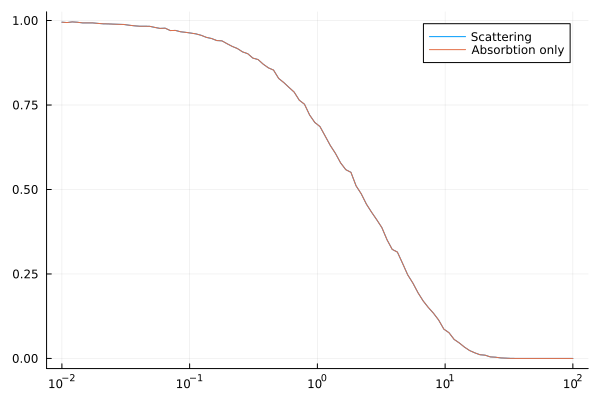

In [50]:
n = 100

esc_prob_no_scatter = zeros(Float64, n)
esc_prob = zeros(Float64, n)
# linspace
optical_depth = 10.0.^LinRange(-2, 2, n)
for i in 1:n
    esc_prob[i] = mcrt(
        100,
        x -> 1 / (x + 1e-6)^2,
        Params(
            0.3,
            0.1,
            optical_depth[i],
            true
        )
    )

    # esc_prob_no_scatter[i] = mcrt(
    #     100,
    #     x -> 1 / (x + 1e-6)^2,
    #     Params(
    #         0.3,
    #         0.1,
    #         optical_depth[i],
    #         false
    #     )
    # )
end

# print difference between the two cases
mse = sum((esc_prob .- esc_prob_no_scatter).^2) / n
println("Mean Squared Error: ", mse)
# x axis in log
plot(optical_depth, esc_prob_list, xaxis=:log, label="Scattering")
plot!(optical_depth, esc_prob_list_no_scatter, xaxis=:log, label="Absorbtion only")